In [1]:
# Cell 1: Imports and Configuration (v3.1 - NO DATA LEAKAGE)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import warnings
import sys
import os

sys.path.insert(0, os.getcwd())

from feature_engineering import (
    add_temporal_features,
    add_festival_features,
    add_seasonal_features,
    create_lag_features,
    create_rolling_features,
    INDIAN_FESTIVALS,
    fetch_calendarific_holidays
)

warnings.filterwarnings('ignore')

# --- PATH CONFIGURATION ---
BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
ARTIFACT_DIR = Path("artifacts/xgb_models-3.1-no-leakage")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# --- API KEY ---
CALENDARIFIC_API_KEY = "Tk4OoTvXa55377qkM2dUSAM5RxMpEb2f"

# --- MODEL CONFIGURATION ---
TARGETS = ['O3_target', 'NO2_target']
LAGS = [1, 2, 3, 6, 12, 24]
ROLLING_WINDOWS = [6, 24]

FORECAST_FEATURES = [
    'O3_forecast', 'NO2_forecast', 'T_forecast', 'q_forecast',
    'u_forecast', 'v_forecast', 'w_forecast'
]

TEMPORAL_FEATURES = [
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
    'is_weekend', 'is_rush_hour', 'is_morning_rush', 'is_evening_rush',
    'is_night', 'is_business_hours'
]

FESTIVAL_FEATURES = [
    'is_festival_day', 'festival_impact', 'is_diwali_period', 'is_public_holiday'
]

SEASONAL_FEATURES = [
    'is_winter', 'is_summer', 'is_monsoon', 'is_post_monsoon',
    'is_crop_burning_season', 'is_inversion_likely'
]

XGB_PARAMS = {
    'n_estimators': 1500,
    'learning_rate': 0.03,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'early_stopping_rounds': 75,
    'random_state': 42,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

print("✅ Configuration Loaded (v3.1 - NO DATA LEAKAGE)")
print(f"📂 Data Directory: {DATA_DIR}")
print(f"📂 Artifacts Directory: {ARTIFACT_DIR}")
print("\n🛡️ LEAKAGE FIXES APPLIED:")
print("   1. Interpolation: forward-only (no future values)")
print("   2. Split: Train/Validation/Test (70/10/20)")
print("   3. Early stopping uses VALIDATION set, not test set")

✅ Configuration Loaded (v3.1 - NO DATA LEAKAGE)
📂 Data Directory: /Users/pushkalpratapsingh/Downloads/PROJECTSS/untitled folder/PS2-SIH25/ML/Data_SIH_2025 2
📂 Artifacts Directory: artifacts/xgb_models-3.1-no-leakage

🛡️ LEAKAGE FIXES APPLIED:
   1. Interpolation: forward-only (no future values)
   2. Split: Train/Validation/Test (70/10/20)
   3. Early stopping uses VALIDATION set, not test set


In [4]:
# Cell 2: Helper Functions (LEAKAGE-FREE)

def R2_SAFE(r2):
    return max(r2, -1.0)

def calculate_metrics(y_true, y_pred, site_name, target_name):
    return {
        'Site': site_name,
        'Target': target_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': R2_SAFE(r2_score(y_true, y_pred)),
        'Bias': np.mean(y_pred - y_true)
    }

def process_site_data_no_leakage(file_path, holidays_cache=None):
    """
    LEAKAGE-FREE data processing pipeline.
    
    Key changes:
    - Interpolation uses 'forward' only (no future values)
    - Rolling/lag features use past values only (already safe)
    """
    df = pd.read_csv(file_path)
    
    # Create datetime and sort
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']].astype(int))
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # FIX 1: Interpolate using FORWARD only (no future data leakage)
    for col in FORECAST_FEATURES:
        if col in df.columns:
            # Forward fill first, then backward fill only for leading NaNs
            df[col] = df[col].interpolate(method='linear', limit_direction='forward')
            # Fill any remaining leading NaNs with first valid value
            df[col] = df[col].bfill()
    
    # Add temporal features (safe - based on timestamp only)
    df = add_temporal_features(df)
    
    # Add festival features (safe - deterministic calendar lookup)
    df = add_festival_features(df, INDIAN_FESTIVALS)
    
    # Add seasonal features (safe - based on month only)
    df = add_seasonal_features(df)
    
    # Add public holidays (safe - known in advance)
    if holidays_cache:
        df['date_str'] = df['datetime'].dt.strftime('%Y-%m-%d')
        df['is_public_holiday'] = df['date_str'].isin(holidays_cache.keys()).astype(int)
        df = df.drop(columns=['date_str'])
    else:
        df['is_public_holiday'] = 0
    
    # Create lag features (safe - shift uses past values only)
    df = create_lag_features(df, TARGETS, LAGS)
    
    # Create rolling features (safe - uses past values only)
    df = create_rolling_features(df, TARGETS, ROLLING_WINDOWS)
    
    return df

print("✅ Leakage-Free Helper Functions Defined")

✅ Leakage-Free Helper Functions Defined


In [6]:
# Cell 3: Fetch holidays from Calendarific API

print("🌐 Fetching holidays from Calendarific API...")
print("="*60)

all_holidays = {}
for year in range(2019, 2025):
    holidays = fetch_calendarific_holidays(CALENDARIFIC_API_KEY, "IN", year)
    all_holidays.update(holidays)
    print(f"✅ {year}: {len(holidays)} holidays fetched")

print(f"\n📅 Total holidays cached: {len(all_holidays)}")

🌐 Fetching holidays from Calendarific API...
✅ 2019: 62 holidays fetched
✅ 2020: 63 holidays fetched
✅ 2021: 66 holidays fetched
✅ 2022: 65 holidays fetched
✅ 2023: 67 holidays fetched
✅ 2024: 65 holidays fetched

📅 Total holidays cached: 388


TRAINING PIPELINE v3.1 (NO DATA LEAKAGE)

🛡️ Using 3-way split: Train (70%) / Validation (10%) / Test (20%)
   - Early stopping monitors VALIDATION set (not test)
   - Test set is completely held out until final evaluation

📍 PROCESSING SITE 1
   ------------------------------------------------
   Features: 51 | Train: 17539 | Val: 2506 | Test: 5012
       > O3_target    | R2: 0.9652 | MAE: 2.10 | RMSE: 5.11
       > NO2_target   | R2: 0.8997 | MAE: 4.61 | RMSE: 8.46


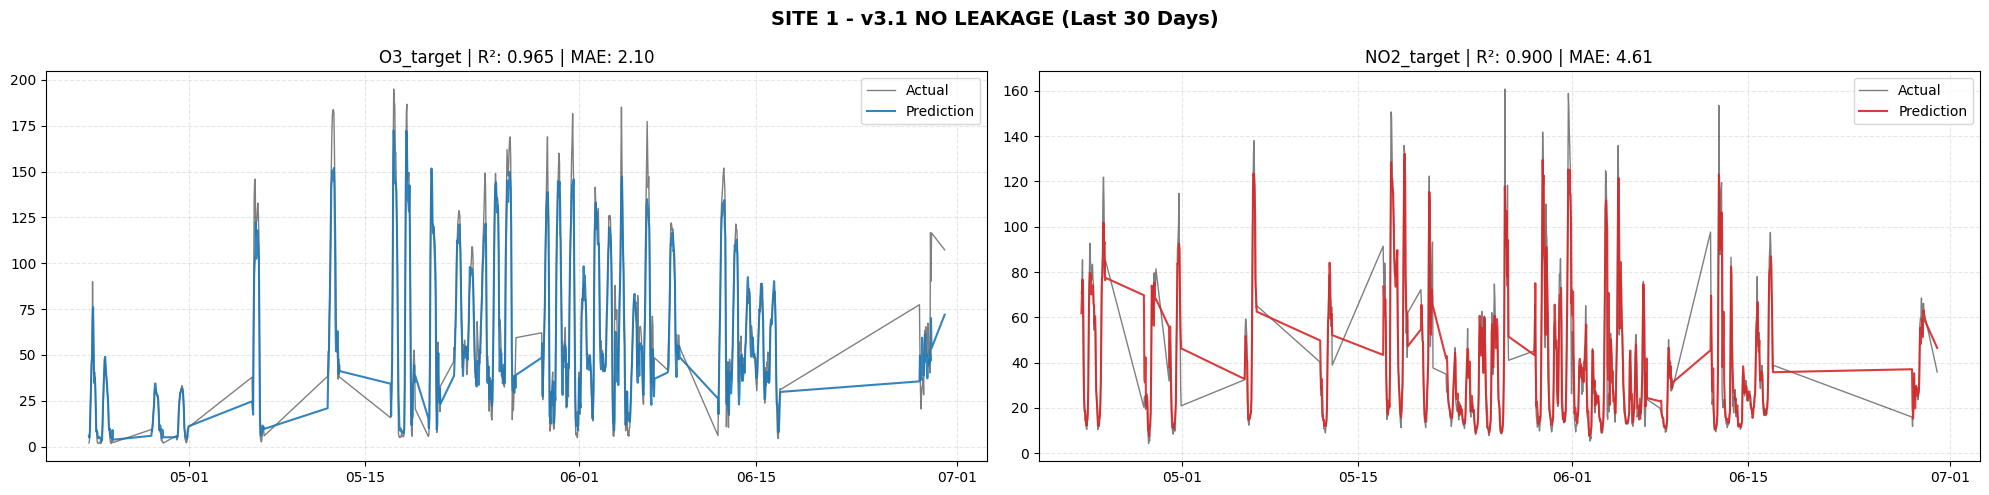


📍 PROCESSING SITE 2
   ------------------------------------------------
   Features: 51 | Train: 18161 | Val: 2595 | Test: 5189
       > O3_target    | R2: 0.9537 | MAE: 3.20 | RMSE: 5.74
       > NO2_target   | R2: 0.9225 | MAE: 3.75 | RMSE: 6.14


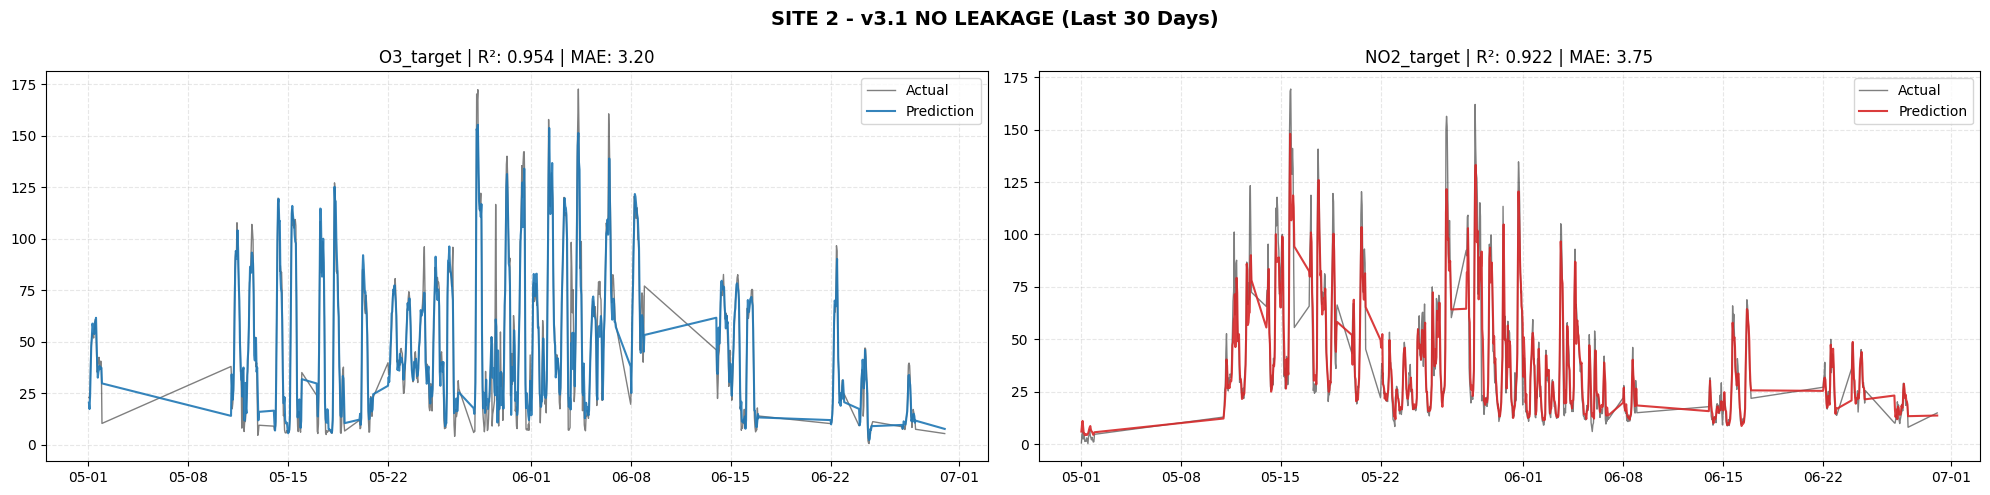


📍 PROCESSING SITE 3
   ------------------------------------------------
   Features: 51 | Train: 15322 | Val: 2189 | Test: 4378
       > O3_target    | R2: 0.9538 | MAE: 5.00 | RMSE: 8.31
       > NO2_target   | R2: 0.9375 | MAE: 4.91 | RMSE: 7.40


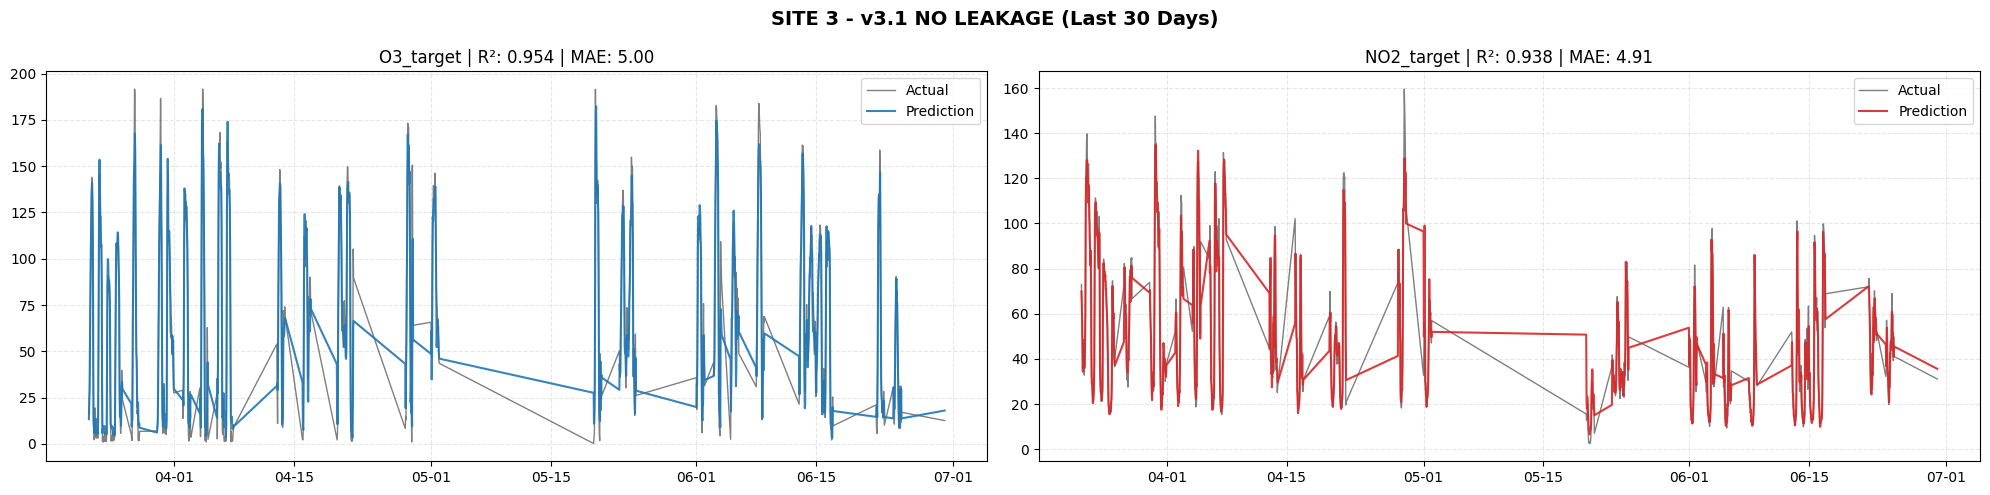


📍 PROCESSING SITE 4
   ------------------------------------------------
   Features: 51 | Train: 17136 | Val: 2448 | Test: 4897
       > O3_target    | R2: 0.9651 | MAE: 4.27 | RMSE: 7.04
       > NO2_target   | R2: 0.9140 | MAE: 3.67 | RMSE: 5.54


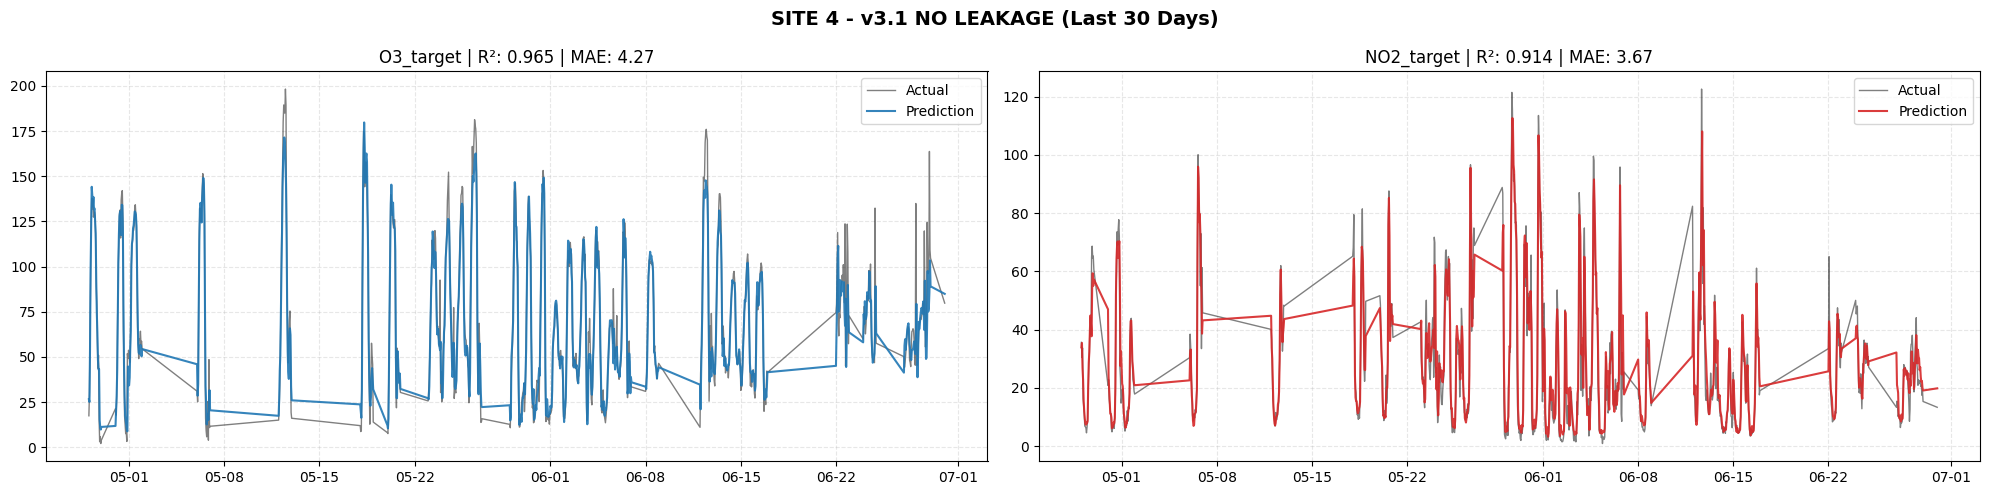


📍 PROCESSING SITE 5
   ------------------------------------------------
   Features: 51 | Train: 17539 | Val: 2506 | Test: 5012
       > O3_target    | R2: 0.9616 | MAE: 3.93 | RMSE: 6.59
       > NO2_target   | R2: 0.9204 | MAE: 6.48 | RMSE: 11.62


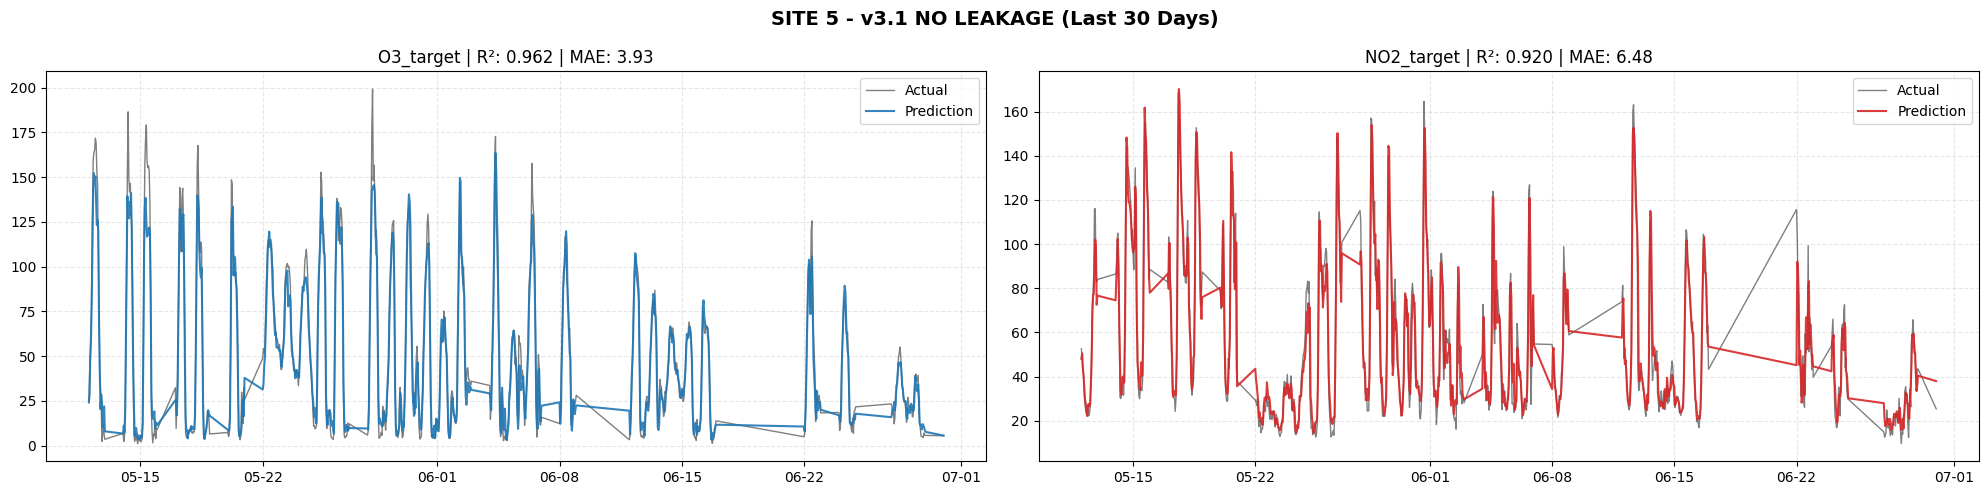


📍 PROCESSING SITE 6
   ------------------------------------------------
   Features: 51 | Train: 18430 | Val: 2633 | Test: 5266
       > O3_target    | R2: 0.8313 | MAE: 7.19 | RMSE: 15.04
       > NO2_target   | R2: 0.8564 | MAE: 4.56 | RMSE: 8.52


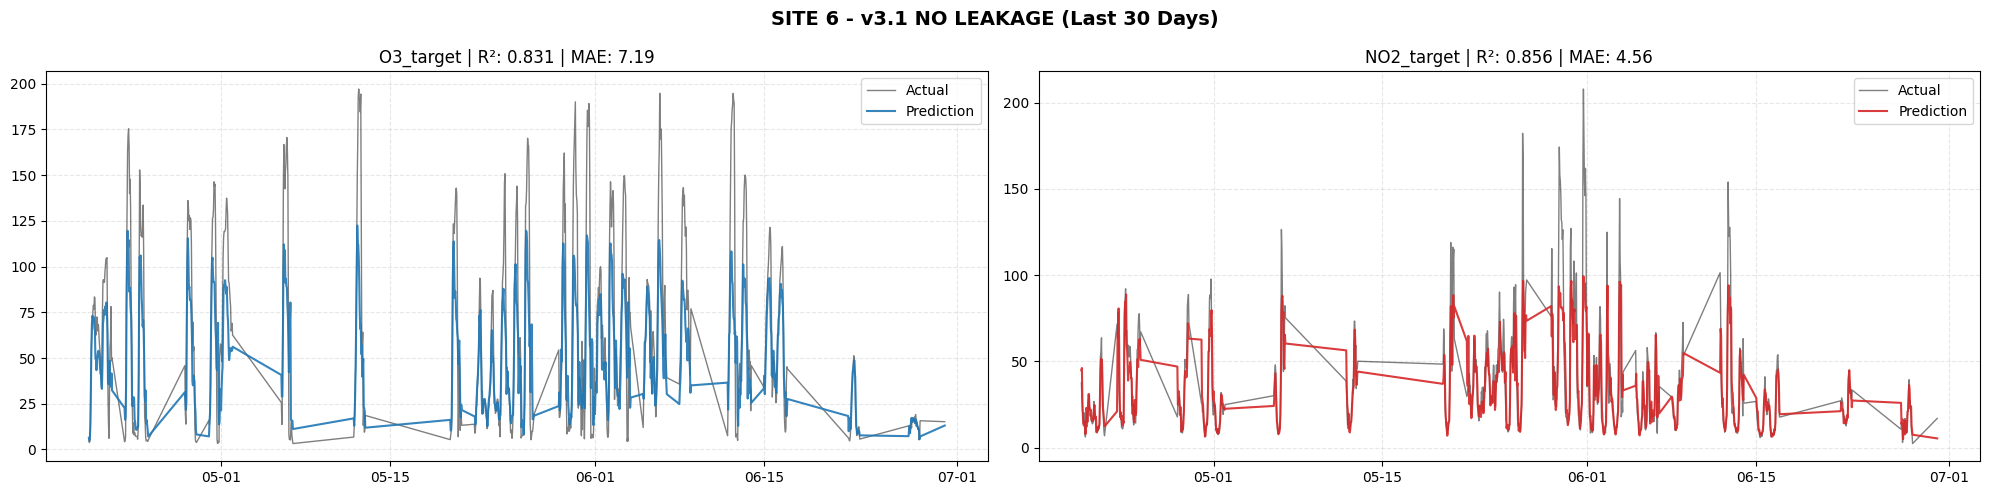


📍 PROCESSING SITE 7
   ------------------------------------------------
   Features: 51 | Train: 15927 | Val: 2275 | Test: 4551
       > O3_target    | R2: 0.9603 | MAE: 4.31 | RMSE: 7.06
       > NO2_target   | R2: 0.9286 | MAE: 3.15 | RMSE: 5.31


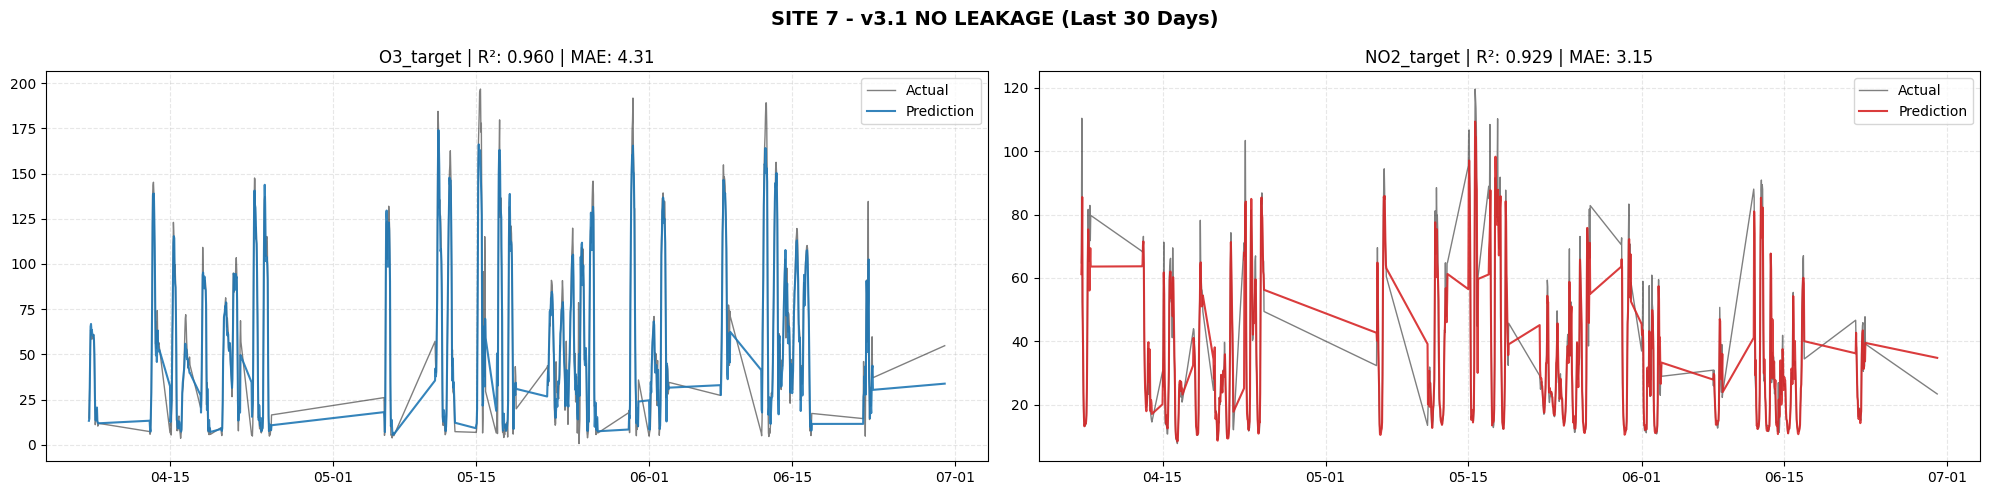

In [7]:
# Cell 4: Training Pipeline (LEAKAGE-FREE with Train/Val/Test split)

all_metrics = []
feature_importance_all = {}

print(f"{'='*100}")
print("TRAINING PIPELINE v3.1 (NO DATA LEAKAGE)")
print(f"{'='*100}")
print("\n🛡️ Using 3-way split: Train (70%) / Validation (10%) / Test (20%)")
print("   - Early stopping monitors VALIDATION set (not test)")
print("   - Test set is completely held out until final evaluation\n")

for site_id in range(1, 8):
    file_path = DATA_DIR / f"site_{site_id}_train_data.csv"
    if not file_path.exists():
        print(f"⚠️ Skipping Site {site_id} (File not found)")
        continue
    
    print(f"📍 PROCESSING SITE {site_id}")
    print(f"   ------------------------------------------------")
    
    # Process data with leakage-free pipeline
    df_processed = process_site_data_no_leakage(file_path, holidays_cache=all_holidays)
    
    # Build feature list
    lag_features = [col for col in df_processed.columns if 'lag' in col]
    rolling_features = [col for col in df_processed.columns if 'rolling' in col]
    
    all_features = (
        FORECAST_FEATURES +
        TEMPORAL_FEATURES +
        FESTIVAL_FEATURES +
        SEASONAL_FEATURES +
        lag_features +
        rolling_features
    )
    
    feature_cols = [f for f in all_features if f in df_processed.columns]
    
    # Drop NaN rows
    cols_to_check = TARGETS + feature_cols
    df_processed = df_processed.dropna(subset=cols_to_check).reset_index(drop=True)
    
    # FIX 2: 3-WAY TEMPORAL SPLIT (Train/Validation/Test)
    n = len(df_processed)
    train_end = int(n * 0.70)
    val_end = int(n * 0.80)
    
    train_df = df_processed.iloc[:train_end]
    val_df = df_processed.iloc[train_end:val_end]
    test_df = df_processed.iloc[val_end:]
    
    print(f"   Features: {len(feature_cols)} | Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(f"SITE {site_id} - v3.1 NO LEAKAGE (Last 30 Days)", fontsize=14, fontweight='bold')
    
    for idx, target in enumerate(TARGETS):
        # Train model with VALIDATION set for early stopping (not test!)
        model = xgb.XGBRegressor(**XGB_PARAMS)
        model.fit(
            train_df[feature_cols], train_df[target],
            eval_set=[(val_df[feature_cols], val_df[target])],  # FIX: Use VAL, not TEST
            verbose=False
        )
        
        # Evaluate on HELD-OUT TEST set
        y_pred = model.predict(test_df[feature_cols])
        
        m = calculate_metrics(test_df[target], y_pred, f"site_{site_id}", target)
        all_metrics.append(m)
        print(f"       > {target:<12} | R2: {m['R2']:.4f} | MAE: {m['MAE']:.2f} | RMSE: {m['RMSE']:.2f}")
        
        model.save_model(ARTIFACT_DIR / f"site_{site_id}_{target}_xgb.json")
        
        importance = pd.Series(
            model.feature_importances_,
            index=feature_cols
        ).sort_values(ascending=False)
        feature_importance_all[f"site_{site_id}_{target}"] = importance
        
        # Plot
        ax = axes[idx]
        zoom_hours = 720
        if len(test_df) > zoom_hours:
            plot_dates = test_df['datetime'].iloc[-zoom_hours:]
            plot_true = test_df[target].iloc[-zoom_hours:]
            plot_pred = y_pred[-zoom_hours:]
        else:
            plot_dates = test_df['datetime']
            plot_true = test_df[target]
            plot_pred = y_pred
        
        ax.plot(plot_dates, plot_true, color='black', alpha=0.5, label='Actual', linewidth=1)
        color = '#d62728' if 'NO2' in target else '#1f77b4'
        ax.plot(plot_dates, plot_pred, color=color, alpha=0.9, label='Prediction', linewidth=1.5)
        
        ax.set_title(f"{target} | R²: {m['R2']:.3f} | MAE: {m['MAE']:.2f}")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(ARTIFACT_DIR / f"site_{site_id}_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()
    print()

FEATURE IMPORTANCE ANALYSIS (v3.1 - No Leakage)

TOP 25 MOST IMPORTANT FEATURES:

NO2_target_lag_1             0.218833
O3_target_lag_1              0.210141
O3_target_lag_24             0.076654
NO2_target_rolling_mean_6    0.059068
hour_sin                     0.046472
is_morning_rush              0.037096
is_rush_hour                 0.035636
NO2_target_lag_2             0.029242
O3_target_rolling_mean_6     0.027361
O3_target_lag_2              0.025881
NO2_target_rolling_std_6     0.025493
O3_target_rolling_std_6      0.019340
NO2_target_lag_24            0.018534
hour_cos                     0.014895
NO2_target_lag_3             0.011363
is_night                     0.010423
O3_target_rolling_std_24     0.009733
is_monsoon                   0.008579
O3_target_lag_6              0.008514
O3_target_lag_3              0.007901
is_evening_rush              0.006958
NO2_target_lag_6             0.006700
is_winter                    0.006441
NO2_target_rolling_std_24    0.004849
is_bus

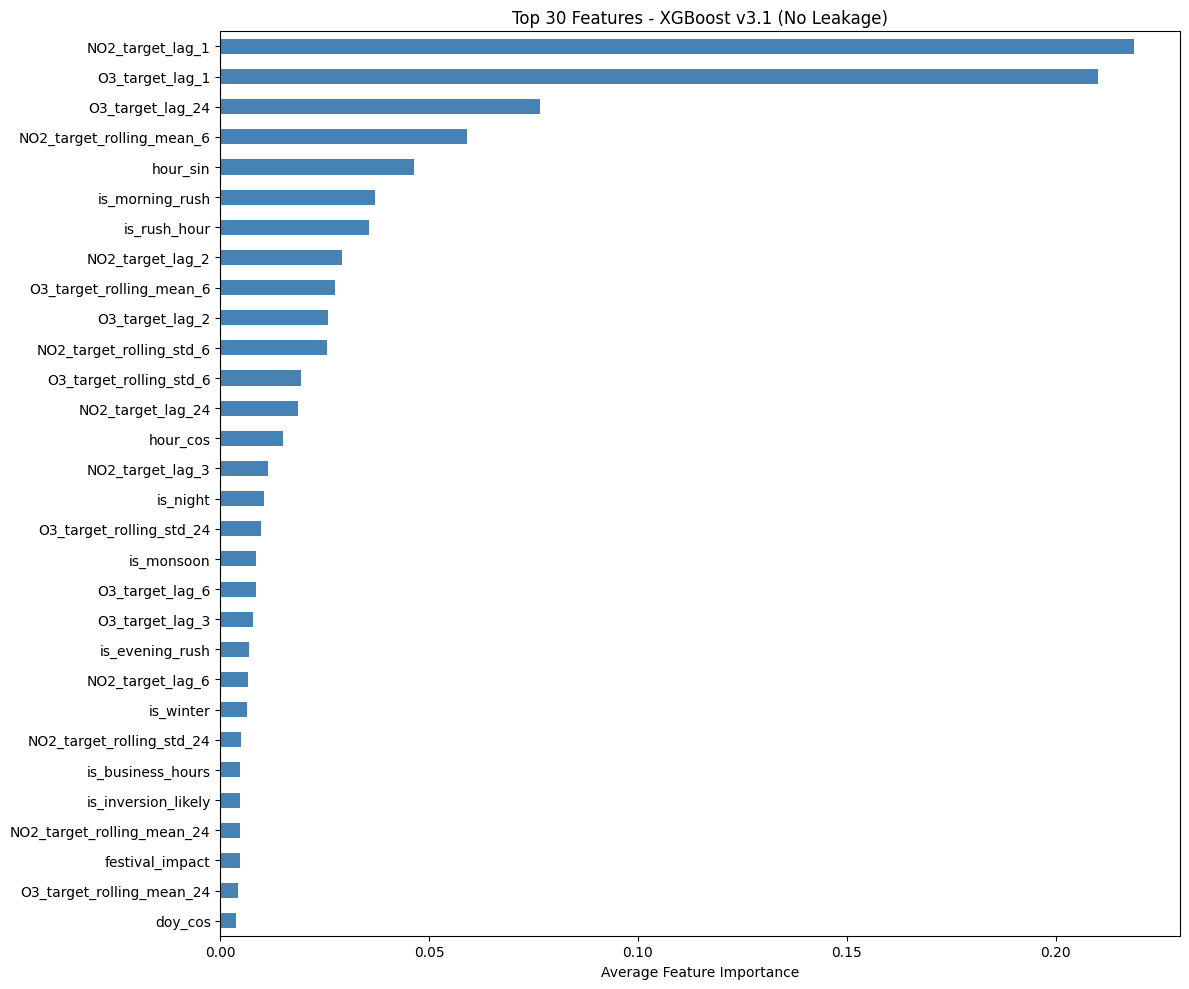


NEW CALENDAR/TEMPORAL FEATURES IMPORTANCE:

hour_sin                  0.046472
is_morning_rush           0.037096
is_rush_hour              0.035636
hour_cos                  0.014895
is_night                  0.010423
is_monsoon                0.008579
is_evening_rush           0.006958
is_winter                 0.006441
is_business_hours         0.004738
is_inversion_likely       0.004671
festival_impact           0.004662
doy_cos                   0.003822
month_cos                 0.003432
is_diwali_period          0.003273
is_summer                 0.003167
is_crop_burning_season    0.003155
is_post_monsoon           0.003091
is_festival_day           0.002967
doy_sin                   0.002945
month_sin                 0.002854
is_public_holiday         0.001661
is_weekend                0.001580
dow_cos                   0.001522
dow_sin                   0.001511


In [8]:
# Cell 5: Feature Importance Analysis

print(f"{'='*80}")
print("FEATURE IMPORTANCE ANALYSIS (v3.1 - No Leakage)")
print(f"{'='*80}\n")

importance_df = pd.DataFrame(feature_importance_all)
all_importance = importance_df.mean(axis=1).sort_values(ascending=False)

print("TOP 25 MOST IMPORTANT FEATURES:\n")
print(all_importance.head(25).to_string())

fig, ax = plt.subplots(figsize=(12, 10))
all_importance.head(30).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Average Feature Importance')
ax.set_title('Top 30 Features - XGBoost v3.1 (No Leakage)')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(ARTIFACT_DIR / 'feature_importance.png', dpi=150)
plt.show()

print("\n" + "="*80)
print("NEW CALENDAR/TEMPORAL FEATURES IMPORTANCE:")
print("="*80 + "\n")

new_features = TEMPORAL_FEATURES + FESTIVAL_FEATURES + SEASONAL_FEATURES
new_feature_importance = all_importance[all_importance.index.isin(new_features)]
print(new_feature_importance.sort_values(ascending=False).to_string())

In [10]:
# Cell 6: Final Summary & Comparison

results_df = pd.DataFrame(all_metrics)

print(f"{'='*80}")
print("FINAL SUMMARY - XGBoost v3.1 (NO DATA LEAKAGE)")
print(f"{'='*80}")
print(results_df.round(4).to_string(index=False))

print(f"\n{'='*80}")
print("AVERAGE METRICS ACROSS ALL 7 SITES")
print(f"{'='*80}")
avg_metrics = results_df.groupby('Target')[['R2', 'MAE', 'RMSE', 'Bias']].mean()
print(avg_metrics.round(4).to_string())

results_df.to_csv(ARTIFACT_DIR / "final_metrics_report_v3.1.csv", index=False)
avg_metrics.to_csv(ARTIFACT_DIR / "average_metrics_summary_v3.1.csv")

print(f"\n📄 All artifacts saved to: {ARTIFACT_DIR}")

# Compare with v3.0 (leaky) and v2.0
print(f"\n{'='*80}")
print("COMPARISON: v3.1 (No Leakage) vs v3.0 (Leaky) vs v2.0")
print(f"{'='*80}")

v3_path = Path("artifacts/xgb_models-3.0/average_metrics_summary_v3.csv")
v2_path = Path("artifacts/xgb_models-2.0/average_metrics_summary.csv")

print("\n📊 v3.1 (NO LEAKAGE) - Current:")
print(avg_metrics.reset_index().round(4).to_string(index=False))

if v3_path.exists():
    v3_avg = pd.read_csv(v3_path)
    print("\n📊 v3.0 (WITH LEAKAGE):")
    print(v3_avg.round(4).to_string(index=False))

if v2_path.exists():
    v2_avg = pd.read_csv(v2_path)
    print("\n📊 v2.0 (Baseline):")
    print(v2_avg.round(4).to_string(index=False))

print("\n" + "="*80)
print("🛡️ Note: v3.1 metrics are REALISTIC (no data leakage).")
print("   If v3.0 > v3.1, the difference was due to leakage, not real improvement.")
print("="*80)

FINAL SUMMARY - XGBoost v3.1 (NO DATA LEAKAGE)
  Site     Target    MAE    RMSE     R2    Bias
site_1  O3_target 2.1025  5.1132 0.9652 -0.1567
site_1 NO2_target 4.6120  8.4573 0.8997 -0.2247
site_2  O3_target 3.1970  5.7368 0.9537  0.3031
site_2 NO2_target 3.7508  6.1444 0.9225 -0.0585
site_3  O3_target 5.0030  8.3063 0.9538  0.1484
site_3 NO2_target 4.9054  7.4036 0.9375  0.9829
site_4  O3_target 4.2745  7.0364 0.9651 -0.2711
site_4 NO2_target 3.6693  5.5416 0.9140  0.6367
site_5  O3_target 3.9307  6.5911 0.9616 -0.5623
site_5 NO2_target 6.4788 11.6237 0.9204 -0.7288
site_6  O3_target 7.1945 15.0408 0.8313 -2.7201
site_6 NO2_target 4.5625  8.5245 0.8564 -0.9917
site_7  O3_target 4.3066  7.0634 0.9603  0.1772
site_7 NO2_target 3.1502  5.3138 0.9286 -0.1316

AVERAGE METRICS ACROSS ALL 7 SITES
                R2    MAE    RMSE    Bias
Target                                   
NO2_target  0.9113  4.447  7.5727 -0.0737
O3_target   0.9416  4.287  7.8411 -0.4402

📄 All artifacts saved to: ar